# Libraries

In [1]:
# !pip install wfdb

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Ridge
from matplotlib.colors import Normalize
import networkx as nx
from scipy.signal import welch
import matplotlib.cm as cm
import seaborn as sns
from collections import defaultdict
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch.optim import Adam

# Utils

In [3]:
def scale_spectral_radius(W, target_radius=0.95):
    eigvals = np.linalg.eigvals(W)
    radius = np.max(np.abs(eigvals))
    if radius == 0:
        return W
    return (W / radius) * target_radius

In [4]:
def create_delay_embedding(signal, embed_dim):
    L = len(signal) - embed_dim + 1
    emb = np.zeros((L, embed_dim))
    for i in range(L):
        emb[i, :] = signal[i:i+embed_dim]
    return emb

# Baselines

### Baseline ESN

In [5]:
class BaselineESN3D:
    """
    A baseline Echo State Network that handles:
        - 3D input (x,y,z)
        - 3D output (x(t+1), y(t+1), z(t+1))"
    """
    def __init__(self,
                 reservoir_size=400,
                 spectral_radius=0.95,
                 connectivity=0.1,
                 input_scale=1.0,
                 leaking_rate=0.8,
                 ridge_alpha=1e-6,
                 activation_choices=('tanh','relu','sin','linear'),
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.activation_choices = activation_choices
        self.seed = seed

        np.random.seed(self.seed)
        # Initialize W with small random values (mean=0, variance=0.01)
        W = np.random.randn(reservoir_size, reservoir_size) * 0.1
        # Create a boolean sparsity mask
        mask = (np.random.rand(reservoir_size, reservoir_size) < self.connectivity)
        W = W * mask
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed + 100)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _apply_activation(self, act_type, val):
        return np.tanh(val)
        # if act_type=='tanh':
        #     return np.tanh(val)
        # elif act_type=='relu':
        #     return max(0.0, val)
        # elif act_type=='sin':
        #     return np.sin(val)
        # elif act_type=='linear':
        #     return val
        # else:
        #     return np.tanh(val)

    def _update(self, u):
        """
        x(t+1) = (1-alpha)*x(t) + alpha*[ node-by-node activation( W*x(t)+W_in*u ) ]
        """
        pre_activations = self.W @ self.x + self.W_in @ u
        x_new = np.zeros_like(self.x)
        for i in range(self.reservoir_size):
            activation = self.node_activations[i]
            x_new[i] = self._apply_activation(activation, pre_activations[i])
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new
        
    def collect_states(self, inputs, discard=100):
        """
        Run reservoir on 'inputs' (shape [T, 3]), discarding the first 'discard' steps.
        Returns: states [T-discard, reservoir_size]
        """
        self.reset_state()
        states = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]
    

    def fit_readout(self, train_input, train_target, discard=100):
        """
        Teacher forcing for single-step:
            - input(t) = [x(t), y(t), z(t)]
            - target(t) = [x(t+1), y(t+1), z(t+1)]
        We collect states(t), then solve a multi-output linear ridge regression:
            W_out * [x(t); 1] ~ target(t+1).
        For quadratic readout:
            W_out * [x(t); x²(t); 1] ~ target(t+1).
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]  # shape [T-discard, 3]

        # Augment states with bias
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0], 1))])  # shape [T-discard, N+1]

        # Quadratic readout
        # Build augmented matrix [ x, x^2, 1 ]
        X_list = []
        for s in states_use:
            X_list.append( np.concatenate([s, s**2, [1.0]]) )
        X_aug = np.array(X_list)                                # shape [T-discard, 2N+1]

        ridge_reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        ridge_reg.fit(X_aug, targets_use)
        self.W_out = ridge_reg.coef_

    def predict(self, inputs):
        """
        Single-step-ahead inference on test data:
        For each inputs[t], we update reservoir, then read out 3D prediction.
        """
        preds = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = np.concatenate([self.x, (self.x)**2, [1.0]])  # For quadrartic readout
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)
    
    def autoregressive_predict(self, initial_input, num_steps):
        """
        Autoregressive multi-step forecasting for num_steps
        """
        preds = []
        current_input = initial_input.copy()
      
        for _ in range(num_steps):
            self._update(current_input)
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = np.concatenate([self.x, (self.x)**2, [1.0]])  # For quadratic readout
            out = self.W_out @ x_aug
            preds.append(out)
            current_input = out
        
        return np.array(preds)

### SCR

In [6]:
class CycleReservoir3D(BaselineESN3D):
    """
    Cyclic Reservoir for 3D -> 3D Lorenz.
    - reservoir_size, spectral_radius, input_scale, leaking_rate, ridge_alpha as in baseline
    """
    def __init__(self,
                 reservoir_size=400,
                 spectral_radius=0.95,
                 cycle_weight = 0.8,
                 input_scale=1.0,
                 leaking_rate=0.8,
                 ridge_alpha=1e-6,
                 activation_choices=('tanh','relu','sin','linear'),
                 seed=42):
        
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.cycle_weight = cycle_weight
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.activation_choices = activation_choices
        self.seed = seed

        np.random.seed(self.seed)
        # Build cycle adjacency: W[i,(i+1)%N] = 1
        W = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            j = (i+1) % reservoir_size
            W[i, j] = cycle_weight

        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed + 100)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()


### CRJ

In [7]:
class CRJRes3D(BaselineESN3D):
    def __init__(self,
                 reservoir_size=300,
                 edge_weight = 0.8,
                 jump=10,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 activation_choices=('tanh','relu','sin','linear'),
                 seed=42):
        
        self.reservoir_size = reservoir_size
        self.edge_weight = edge_weight
        self.jump = jump
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.activation_choices = activation_choices
        self.seed = seed

        np.random.seed(self.seed)
        W = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            W[i, (i+1) % reservoir_size] = edge_weight              # Cycle edge
            W[i, (i + self.jump) % reservoir_size] = edge_weight    # Jump edge

        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed+100)
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()

### MCI-ESN

In [8]:
class MCIESN3D:
    def __init__(self,
                 reservoir_size=300,
                 cycle_weight=0.8,
                 connect_weight=0.8,
                 combine_factor=0.5,
                 v1=0.6,
                 v2=0.6,
                 spectral_radius=0.95,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42
                 ):
        self.reservoir_size = reservoir_size
        self.cycle_weight = cycle_weight
        self.connect_weight = connect_weight
        self.combine_factor = combine_factor
        self.v1 = v1
        self.v2 = v2
        self.spectral_radius = spectral_radius
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        W_res = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            j = (i+1) % reservoir_size
            W_res[j, i] = self.cycle_weight

        W_res = scale_spectral_radius(W_res, spectral_radius)
        self.W_res = W_res                      # shared by both sub-reservoirs

        np.random.seed(self.seed + 100)
        W_cn = np.zeros((reservoir_size, reservoir_size))
        W_cn[0, reservoir_size-1] = self.connect_weight
        W_cn[reservoir_size-1, 0] = self.connect_weight
        self.W_cn = W_cn

        np.random.seed(self.seed+200)

        sign_V1 = np.random.choice([-1, 1], size=(reservoir_size, 3))
        sign_V2 = np.random.choice([-1, 1], size=(reservoir_size, 3))

        V1 = self.v1 * sign_V1
        V2 = self.v2 * sign_V2

        self.W_in1 = V1 - V2
        self.W_in2 = V1 + V2
        
        self.W_out = None

    def reset_state(self):
        self.x1 = np.zeros(self.reservoir_size)
        self.x2 = np.zeros(self.reservoir_size)

    def _update(self, u):
        """
        Single-step reservoir update.
        x1(t+1) = cos( Win1*u(t+1) + W_res*x1(t) + W_cn*x2(t) )
        x2(t+1) = sin( Win2*u(t+1) + W_res*x2(t) + W_cn*x1(t) )
        Then x(t+1)= h*x1(t+1) + (1-h)* x2(t+1).
        """
        # pre activation for reservoir1
        pre_activation1 = self.W_in1 @ u + self.W_res @ self.x1 + self.W_cn @ self.x2
        # reservoir1 uses cos
        x1_new = np.cos(pre_activation1)

        # reservoir2 uses sin
        pre_activation2 = self.W_in2 @ u + self.W_res @ self.x2 + self.W_cn @ self.x1
        x2_new = np.sin(pre_activation2)

        alpha = self.leaking_rate
        self.x1 = (1.0 - alpha)*self.x1 + alpha*x1_new
        self.x2 = (1.0 - alpha)*self.x2 + alpha*x2_new

    def _combine_state(self):
        """
        Combine x1(t), x2(t) => x(t) = h*x1(t) + (1-h)*x2(t)
        """
        h = self.combine_factor
        return h*self.x1 + (1.0 - h)*self.x2
    
    def collect_states(self, inputs, discard=100):
        self.reset_state()
        states = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            combined = self._combine_state()
            states.append(combined.copy())
        states = np.array(states)
        return states[discard:], states[:discard]
    
    def fit_readout(self, train_input, train_target, discard=100):
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]

        # Augment states with bias
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0], 1))])  # shape [T-discard, N+1]

        # Quadratic readout
        # Build augmented matrix [ x, x^2, 1 ]
        X_list = []
        for s in states_use:
            X_list.append( np.concatenate([s, s**2, [1.0]]) )
        X_aug = np.array(X_list)                                # shape [T-discard, 2N+1]

        ridge_reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        ridge_reg.fit(X_aug, targets_use)
        self.W_out = ridge_reg.coef_

    def predict(self, inputs):
        preds = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            combined = self._combine_state()
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = np.concatenate([combined, combined**2, [1.0]])  # For quadrartic readout
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)
    
    def autoregressive_predict(self, initial_input, num_steps):
        preds = []
        current_input = initial_input.copy()
      
        for _ in range(num_steps):
            self._update(current_input)
            combined = self._combine_state()
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = np.concatenate([combined, combined**2, [1.0]])  # For quadratic readout
            out = self.W_out @ x_aug
            preds.append(out)
            current_input = out
        
        return np.array(preds)

### DeepESN

In [9]:
class DeepESN3D:
    """
    Deep Echo State Network (DeepESN) for multi-layered reservoir computing.
    Each layer has its own reservoir, and the states are propagated through layers.
    """

    def __init__(self,
                 num_layers=3,
                 reservoir_size=100,
                 spectral_radius=0.95,
                 connectivity=0.1,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 activation_choices=('tanh','relu','sin','linear'),
                 seed=42):
        """
        Parameters:
        - num_layers: Number of reservoir layers.
        - reservoir_size: Number of neurons in each reservoir layer.
        """
        self.num_layers = num_layers
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.activation_choices = activation_choices
        self.seed = seed

        # Initialize reservoirs and input weights for each layer
        self.reservoirs = []
        self.input_weights = []
        self.states = []

        np.random.seed(self.seed)
        for layer in range(num_layers):
            np.random.seed(seed + layer)
            W = np.random.randn(reservoir_size, reservoir_size) * 0.1
            mask = (np.random.rand(reservoir_size, reservoir_size) < self.connectivity)
            W = W * mask
            W = scale_spectral_radius(W, spectral_radius)
            self.reservoirs.append(W)

            if layer == 0 : 
                W_in = (np.random.rand(reservoir_size, 3) - 0.5) * 2.0 * input_scale
            else:
                W_in = (np.random.rand(reservoir_size, reservoir_size) - 0.5) * 2.0 * input_scale
            self.input_weights.append(W_in)

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)
        
        self.W_out = None
        self.reset_state()

    def reset_state(self):
        """
        Reset the states of all reservoir layers.
        """
        self.states = [np.zeros(self.reservoir_size) for _ in range(self.num_layers)]

    def _apply_activation(self, act_type, val):
        return np.tanh(val)
        # if act_type=='tanh':
        #     return np.tanh(val)
        # elif act_type=='relu':
        #     return max(0.0, val)
        # elif act_type=='sin':
        #     return np.sin(val)
        # elif act_type=='linear':
        #     return val
        # else:
        #     return np.tanh(val)

    def _update_layer(self, layer_idx, u):
        """
        Update a single reservoir layer.
        """
        pre_activation = self.reservoirs[layer_idx] @ self.states[layer_idx]
        if layer_idx == 0:
            pre_activation += self.input_weights[layer_idx] @ u
        else:
            pre_activation += self.input_weights[layer_idx] @ self.states[layer_idx - 1]

        x_new = np.zeros_like(pre_activation)
        for i in range(self.reservoir_size):
            activation = self.node_activations[i]
            x_new[i] = self._apply_activation(activation, pre_activation[i])
        alpha = self.leaking_rate
        self.states[layer_idx] = (1.0 - alpha) * self.states[layer_idx] + alpha * x_new

    def collect_states(self, inputs, discard=100):
        self.reset_state()
        all_states = []
        for u in inputs:
            for layer_idx in range(self.num_layers):
                self._update_layer(layer_idx, u)
            all_states.append(np.concatenate(self.states))
        all_states = np.array(all_states)
        return all_states[discard:], all_states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        """
        Train the readout layer using ridge regression.
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]

        # Augment states with bias
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0], 1))])  # shape [T-discard, N*L+1]

        # Quadratic readout
        # Build augmented matrix [ x, x^2, 1 ]
        X_list = []
        for s in states_use:
            X_list.append( np.concatenate([s, s**2, [1.0]]) )
        X_aug = np.array(X_list)                                    # shape [T-discard, 2N*L+1]

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict(self, inputs):
        """
        Single-step-ahead inference on test data.
        """
        preds = []
        for u in inputs:
            for layer_idx in range(self.num_layers):
                self._update_layer(layer_idx, u)
            state = np.concatenate(self.states)
            # x_aug = np.concatenate([state, [1.0]])
            x_aug = np.concatenate([state, (state)**2, [1.0]])  # For quadrartic readout
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)

    def autoregressive_predict(self, initial_input, num_steps):
        """
        Autoregressive multi-step forecasting for num_steps
        """
        preds = []
        current_input = initial_input.copy()

        for _ in range(num_steps):
            for layer_idx in range(self.num_layers):
                self._update_layer(layer_idx, current_input)
            state = np.concatenate(self.states)
            # x_aug = np.concatenate([state, [1.0]])
            x_aug = np.concatenate([state, (state)**2, [1.0]])  # For quadrartic readout
            out = self.W_out @ x_aug
            preds.append(out)
            current_input = out
        
        return np.array(preds)

### FSR

In [10]:
def sigmoid(z: np.ndarray, /) -> np.ndarray:
    """Numerically-stable logistic σ : ℝ → (0, 1)."""
    out = np.empty_like(z, dtype=np.float32)
    np.subtract(0.0, z, out)            # out = −z   (no new allocation)
    np.exp(out, out)                    # out = e^(−z)
    out += 1.0                          # 1 + e^(−z)
    np.reciprocal(out, out)             # 1 / (1 + e^(−z))
    return out


def _sample_frequencies(m: int, mode: str = "log") -> np.ndarray:
    """
    Produce m distinct rotation angles θ_i ∈ (0, π).

    * 'log'  : log-uniform in [10⁰·⁰, 10⁰·⁹] Hz then mapped to θ = 2πfΔt
    * 'lin'  : uniform in (0, π)
    * 'gold' : golden-ratio spacing (deterministic)
    """
    if mode == "log":
        # log-spread over ~1 decade, then map to (0, π)
        f = 10 ** np.linspace(0.0, 0.9, m, dtype=np.float32)
        f /= f.max()
        return np.pi * f
    if mode == "lin":
        return np.random.default_rng().uniform(0.01, np.pi - 0.01, size=m)
    if mode == "gold":
        return (np.mod(np.arange(1, m + 1) * 0.61803398875, 1.0) * (np.pi - 0.02) + 0.01)
    raise ValueError("mode must be {'log','lin','gold'}")

def augment_state_with_squares(x):
    """
    Given state vector x in R^N, return [ x, x^2, 1 ] in R^(2N+1).
    We'll use this for both training and prediction.
    """
    x_sq = x**2
    return np.concatenate([x, x_sq, [1.0]])  # shape: 2N+1


# ---------------------------------------------------------------------
# Resonator reservoir class
# ---------------------------------------------------------------------
class FSR3D:
    """
    Frequency-Selective Resonator Echo-State Network.

    • N even ⇒ m = N/2 damped 2-D rotations (planar oscillators)
    • Exact spectral control: eigenvalues r·e^{±iθ_i}
    • Sparse symmetric nearest-neighbour coupling ε·C
    • Optional static gain profile g_k  (sin→σ)  for heterogeneity
    • Optional quadratic + quadrature feature map in the read-out
    """

    # -----------------------------------------------------------------
    def __init__(
        self,
        reservoir_size: int = 400,      # N (must be even)
        frequency_mode: str = "log",    # how to draw θ_i
        r_damp: float = 0.95,           # attenuation per step
        eps_couple: float = 0.05,       # ε   cross-pair mixing strength
        input_scale: float = 0.5,
        leak_rate: float = 1.0,         # α
        ridge_alpha: float = 1e-6,
        use_gain: bool = True,
        gain_beta: float = 2.0,
        gain_sigmoid: bool = True,
        use_quadratic_feat: bool = True,
        seed: int = 42,
    ):
        if reservoir_size % 2:
            raise ValueError("reservoir_size must be even")
        self.N = reservoir_size
        self.m = reservoir_size // 2
        self.r = float(r_damp)
        self.eps = float(eps_couple)
        self.input_scale = input_scale
        self.alpha = leak_rate
        self.ridge_alpha = ridge_alpha
        self.use_gain = use_gain
        self.beta = gain_beta
        self.sig_gain = gain_sigmoid
        self.use_quad = use_quadratic_feat
        self.seed = seed
        self.freq_mode = frequency_mode

        # matrices and state
        self.W_res: np.ndarray | None = None
        self.W_in: np.ndarray | None = None
        self.W_out: np.ndarray | None = None
        self.g: np.ndarray | None = None
        self.x = np.zeros(self.N, dtype=np.float32)

        # one-off construction
        self._build_reservoir()
        self._build_gain()

    # -----------------------------------------------------------------
    # internal builders
    # -----------------------------------------------------------------
    def _build_reservoir(self):
        """
        Build   W_res = G · (R ⊕ ... ⊕ R  +  εC)   without the gain
        (gain applied separately for cheaper runtime multiplication).
        """
        m, r, eps = self.m, self.r, self.eps
        θ = _sample_frequencies(m, mode=self.freq_mode)

        # ----- block-diagonal damped rotations -----------------------
        R_blocks = np.zeros((self.N, self.N), dtype=np.float32)
        for i, theta in enumerate(θ):
            c, s = np.cos(theta) * r, np.sin(theta) * r
            i0 = 2 * i
            R_blocks[i0, i0] = c
            R_blocks[i0, i0 + 1] = -s
            R_blocks[i0 + 1, i0] = s
            R_blocks[i0 + 1, i0 + 1] = c

        # ----- sparse symmetric coupling -----------------------------
        rng = np.random.default_rng(self.seed)
        C = np.zeros_like(R_blocks)
        for i in range(m - 1):                        # nearest-neighbour chain
            b = rng.standard_normal()
            B = np.array([[b, 0.0], [0.0, b]], dtype=np.float32)
            a0, a1 = 2 * i, 2 * (i + 1)
            # upper block
            C[a0 : a0 + 2, a1 : a1 + 2] = B
            # symmetric lower block
            C[a1 : a1 + 2, a0 : a0 + 2] = B.T

        self.W_res = R_blocks + eps * C

    def _build_gain(self):
        """Static per-neuron gain g_k."""
        if not self.use_gain:
            self.g = np.ones(self.N, dtype=np.float32)
            return
        k_idx = np.arange(self.N, dtype=np.float32)
        raw = self.beta * np.sin(2.0 * np.pi * k_idx / self.N)
        self.g = sigmoid(raw) if self.sig_gain else raw.astype(np.float32)

    # -----------------------------------------------------------------
    # reservoir core
    # -----------------------------------------------------------------
    def _update(self, u_t: np.ndarray):
        pre = self.W_res @ self.x + self.W_in @ u_t
        if self.use_gain:
            pre *= self.g
            # pre = self.g*self.W_res @ self.x + self.W_in @ u_t
        
        else:
            pre = self.W_res @ self.x + self.W_in @ u_t

        new_x = np.tanh(pre)
        self.x = (1.0 - self.alpha) * self.x + self.alpha * new_x

    def reset_state(self):
        self.x.fill(0.0)

    # -----------------------------------------------------------------
    # read-out training
    # -----------------------------------------------------------------
    def fit_readout(self, inputs: np.ndarray, targets: np.ndarray, discard: int = 100):
        """
        Teacher-forcing pass to learn W_out via ridge regression.
        * inputs  shape [T, d_in]
        * targets shape [T, d_out]
        """
        T, d_in = inputs.shape
        if T <= discard + 1:
            raise ValueError("Not enough data")

        # random input weights
        rng = np.random.default_rng(self.seed)
        self.W_in = (
            rng.uniform(-1.0, 1.0, size=(self.N, d_in)) * self.input_scale
        ).astype(np.float32)

        # collect echoed states
        self.reset_state()
        states = []
        for t in range(T):
            self._update(inputs[t])
            if t >= discard:
                states.append(self.x.copy())

        X = np.asarray(states, dtype=np.float32)            # [T−d, N]
        Y = targets[discard:]                               # align

        # feature map
        if self.use_quad:
            X_list = []
            for s in X:
                X_list.append(augment_state_with_squares(s))
            feats = np.array(X_list, dtype=np.float32)

        else:
            feats = X

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(feats, Y)
        self.W_out = reg.coef_.astype(np.float32)

    # -----------------------------------------------------------------
    # autoregressive forecast
    # -----------------------------------------------------------------
    def predict_autoregressive(self, init_u: np.ndarray, n_steps: int) -> np.ndarray:
        if self.W_out is None:
            raise RuntimeError("Call fit_readout() before prediction")

        d_in = init_u.shape[0]
        preds = np.empty((n_steps, self.W_out.shape[0]), dtype=np.float32)

        #self.reset_state()
        u_t = init_u.astype(np.float32).copy()

        for t in range(n_steps):
            self._update(u_t)

            if self.use_quad:
                feat_vec = augment_state_with_squares(self.x)
            else:
                feat_vec = self.x

            y_t = (self.W_out @ feat_vec).astype(np.float32)
            preds[t] = y_t
            u_t = y_t[:d_in]

        return preds
    
    def predict_open_loop(self, inputs: np.ndarray):
        preds = []
        for true_input in inputs:
            self._update(true_input)
            if self.use_quad:
                feat_vec = augment_state_with_squares(self.x)
            else:
                feat_vec = self.x
            out = (self.W_out @ feat_vec).astype(np.float32)
            preds.append(out)
        return preds

# LSTM

In [11]:
class LSTMBaseline3D:
    """
    Lightweight single-layer LSTM for 3-dim Lorenz forecasting.
    * hidden_size=32 → ~4.8k trainable parameters
    * fit() trains in teacher-forcing mode
    * predict() produces autoregressive roll-out
    """

    def __init__(self,
                 input_dim:  int = 3,
                 hidden_size: int = 32,
                 output_dim: int = 3,
                 lr: float = 1e-3,
                 epochs: int = 30,
                 device: str = 'cpu',
                 seed: int = 0):
        torch.manual_seed(seed); np.random.seed(seed)

        self.device  = torch.device(device)
        self.epochs  = epochs
        self.model   = nn.LSTM(input_dim, hidden_size,
                               batch_first=True).to(self.device)
        self.head    = nn.Linear(hidden_size, output_dim).to(self.device)
        self.crit    = nn.MSELoss()
        self.optim   = Adam(list(self.model.parameters())+
                            list(self.head.parameters()), lr=lr)

    # ---------------------------------------------------------
    @torch.no_grad()
    def _init_hidden(self, batch_sz=1):
        h0 = torch.zeros(1, batch_sz,
                         self.model.hidden_size,
                         device=self.device)
        c0 = torch.zeros_like(h0)
        return (h0, c0)

    # ---------------------------------------------------------
    def fit(self, x_np: np.ndarray, y_np: np.ndarray):
        """
        x_np shape [T, 3]  (input  at t)
        y_np shape [T, 3]  (target at t)
        """
        x = torch.tensor(x_np, dtype=torch.float32,
                         device=self.device).unsqueeze(0)  # [1,T,3]
        y = torch.tensor(y_np, dtype=torch.float32,
                         device=self.device).unsqueeze(0)

        for _ in range(self.epochs):
            self.optim.zero_grad()
            out, _ = self.model(x, self._init_hidden())
            pred   = self.head(out)
            loss   = self.crit(pred, y)
            loss.backward()
            self.optim.step()

    # ---------------------------------------------------------
    @torch.no_grad()
    def predict(self, init_u: np.ndarray, n_steps: int):
        """
        Autoregressive roll-out.
        init_u : initial 3-vector (last known sample)
        Returns array of shape [n_steps, 3].
        """
        self.model.eval(); self.head.eval()

        inp     = torch.tensor(init_u[None, None, :],
                               dtype=torch.float32, device=self.device)
        h, c    = self._init_hidden()
        preds   = np.empty((n_steps, 3), dtype=np.float32)

        for t in range(n_steps):
            out, (h, c) = self.model(inp, (h, c))
            y           = self.head(out)
            preds[t]    = y.squeeze(0).cpu().numpy()
            inp         = y.detach()    # feed prediction back

        return preds
    
    @torch.no_grad()
    def predict_open_loop(self, x_np: np.ndarray):
        """
        Open-loop prediction using teacher-forced inputs (like during training).
        x_np shape: [T, 3] – input sequence
        Returns:
            preds: [T, 3] – predicted output sequence
        """
        self.model.eval(); self.head.eval()

        x = torch.tensor(x_np, dtype=torch.float32,
                         device=self.device).unsqueeze(0)  # [1, T, 3]
        out, _ = self.model(x, self._init_hidden())
        preds = self.head(out).squeeze(0).cpu().numpy()  # [T, 3]

        return preds

# TCN

In [12]:
class TCNBaseline3D(nn.Module):
    """
    2-layer causal TCN       (kernel=3, dilation=1 & 2, padding chosen
    so receptive field = 5 time-steps).
    ----------------------
    • input_dim  = 3
    • hidden_dim = 32  → total ≈ 4.9 k parameters
    • output_dim = 3    (one-step prediction)
    """
    def __init__(self,
                 input_dim:  int = 3,
                 hidden_dim: int = 32,
                 output_dim: int = 3,
                 lr: float = 1e-3,
                 epochs: int = 40,
                 device: str = "cpu",
                 seed: int = 0):
        super().__init__()
        torch.manual_seed(seed); np.random.seed(seed)

        k = 3  # kernel
        # layer 1: dilation 1  → pad 2 to keep length
        self.conv1 = nn.Conv1d(input_dim, hidden_dim,
                               kernel_size=k,
                               dilation=1,
                               padding=2,
                               bias=True)
        # layer 2: dilation 2  → pad 4
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim,
                               kernel_size=k,
                               dilation=2,
                               padding=4,
                               bias=True)
        self.relu  = nn.ReLU()
        self.head  = nn.Conv1d(hidden_dim, output_dim,
                               kernel_size=1, bias=True)

        self.lr, self.epochs = lr, epochs
        self.to(device)
        self.optim = Adam(self.parameters(), lr=lr)
        self.crit  = nn.MSELoss()

    # ---------------------------------------------------------
    def forward(self, x):
        """
        x shape  [B, T, 3]  (batch, time, channels)
        return  [B, T, 3]
        """
        # reshape to Conv1d convention: (B, C, T)
        x = x.permute(0, 2, 1)
        y = self.conv1(x); y = self.relu(y[:, :, :-2])     # remove look-ahead pad
        y = self.conv2(y); y = self.relu(y[:, :, :-4])     # remove look-ahead pad
        out = self.head(y).permute(0, 2, 1)                # back to (B,T,C)
        return out

    # ---------------------------------------------------------
    def fit(self, x_np: np.ndarray, y_np: np.ndarray):
        """
        Teacher-forcing on entire sequence (batch size = 1).
        x_np, y_np shape [T, 3]
        """
        x = torch.tensor(x_np[None], dtype=torch.float32, device=next(self.parameters()).device)
        y = torch.tensor(y_np[None], dtype=torch.float32, device=next(self.parameters()).device)

        for _ in range(self.epochs):
            self.optim.zero_grad()
            pred = self.forward(x)
            loss = self.crit(pred[:, :-1], y[:, 1:])  # predict next step
            loss.backward()
            self.optim.step()

    # ---------------------------------------------------------
    @torch.no_grad()
    def predict(self, init_window: np.ndarray, n_steps: int):
        """
        Autoregressive roll-out.
        init_window : length L≥5, shape [L,3] (latest samples, earliest first)
        Returns      : [n_steps,3]
        """
        device = next(self.parameters()).device
        window = init_window.copy()
        preds  = np.empty((n_steps, 3), dtype=np.float32)

        for t in range(n_steps):
            inp = torch.tensor(window[None], dtype=torch.float32, device=device)
            y   = self.forward(inp)[0, -1].cpu().numpy()
            preds[t] = y
            window   = np.vstack([window[1:], y])  # slide window

        return preds
    
    @torch.no_grad()
    def predict_open_loop(self, x_np: np.ndarray):
        """
        Open-loop prediction (teacher-forced inputs).
        x_np shape: [T, 3]
        Returns:
            preds: [T - 1, 3] – one-step-ahead predictions
        """
        self.eval()
        device = next(self.parameters()).device

        x = torch.tensor(x_np[None], dtype=torch.float32, device=device)  # [1, T, 3]
        preds = self.forward(x)  # [1, T, 3]
        preds = preds[:, :-1]    # predict from t=0 to t=T-2 for target t=1 to t=T-1

        return preds.squeeze(0).cpu().numpy()



# tcn = TCNBaseline3D(hidden_dim=32, epochs=50, lr=1e-3, device="cpu", seed=46)
# tcn.fit(train_input, train_target)

# # initial window must be >4 samples:
# init_win = test_input[:5].copy()
# tcn_preds = tcn.predict(init_win, n_steps=len(test_target))
# tcn_preds_open_loop = tcn.predict_open_loop(test_input)

### NRMSE

In [13]:
def evaluate_nrmse(all_preds, test_target, horizons):
    """
    Evaluate model performance over multiple prediction horizons
    for teacher-forced single-step forecasting or autoregressive rollout.
    """
    horizon_nrmse = {}
    for horizon in horizons:
        preds = all_preds[:horizon]
        targets = test_target[:horizon]
        squared_errors = (preds - targets) ** 2
        variance = np.var(targets, axis=0)
        variance[variance == 0] = 1e-8  # avoid divide-by-zero
        nrmse = np.sqrt(np.sum(squared_errors) / (horizon * np.sum(variance)))
        horizon_nrmse[horizon] = nrmse
    return horizon_nrmse

### VPT

In [14]:
def compute_valid_prediction_time(y_true, y_pred, test_time, lyapunov_time, threshold=0.4):
    y_mean = np.mean(y_true, axis=0)
    y_centered = y_true - y_mean
    denom = np.mean(np.sum(y_centered**2, axis=1))

    error = y_true - y_pred
    squared_error = np.sum(error**2, axis=1)
    delta = squared_error / denom

    idx_exceed = np.where(delta > threshold)[0]
    if len(idx_exceed) == 0:
        # never exceeds threshold => set T_VPT to the final time
        T_VPT = test_time[-1]
    else:
        T_VPT = test_time[idx_exceed[0]]

    ratio = T_VPT / lyapunov_time

    return T_VPT, ratio

### ADev

In [15]:
def compute_attractor_deviation(predictions, targets, cube_size=(0.1, 0.1, 0.1)):
    """
    Compute the Attractor Deviation (ADev) metric.

    Parameters:
        predictions (numpy.ndarray): Predicted trajectories of shape (n, 3).
        targets (numpy.ndarray): True trajectories of shape (n, 3).
        cube_size (tuple): Dimensions of the cube (dx, dy, dz).

    Returns:
        float: The ADev metric.
    """
    # Define the cube grid based on the range of the data and cube size
    min_coords = np.min(np.vstack((predictions, targets)), axis=0)
    max_coords = np.max(np.vstack((predictions, targets)), axis=0)

    # Create a grid of cubes
    grid_shape = ((max_coords - min_coords) / cube_size).astype(int) + 1

    # Initialize the cube occupancy arrays
    pred_cubes = np.zeros(grid_shape, dtype=int)
    target_cubes = np.zeros(grid_shape, dtype=int)

    # Map trajectories to cubes
    pred_indices = ((predictions - min_coords) / cube_size).astype(int)
    target_indices = ((targets - min_coords) / cube_size).astype(int)

    # Mark cubes visited by predictions and targets
    for idx in pred_indices:
        pred_cubes[tuple(idx)] = 1
    for idx in target_indices:
        target_cubes[tuple(idx)] = 1

    # Compute the ADev metric
    adev = np.sum(np.abs(pred_cubes - target_cubes))
    return adev

### PSD

In [16]:
def compute_psd(y, dt=0.01):
    z = y[:, 2]  # Extract Z-component
    
    # Compute PSD using Welch’s method
    freqs, psd = welch(z, fs=1/dt, window='hamming', nperseg=len(z))  # Using Hamming window
    
    return freqs, psd


# MIT-BIH Dataset

In [17]:
import wfdb

# Download and load record and annotations for patient #100
record = wfdb.rdrecord('100', sampfrom=0, sampto=25002, pn_dir='mitdb')  # first 20,000 samples
annotation = wfdb.rdann('100', 'atr', sampfrom=0, sampto=25002, pn_dir='mitdb')

In [18]:
# Get input signal u(t) from the first channel
u = record.p_signal[:, 0] 
u

array([-0.145, -0.145, -0.145, ..., -0.41 , -0.415, -0.425],
      shape=(25002,))

In [19]:
# Normalize input
u_min = np.min(u)
u_max = np.max(u)
u_norm = (u - u_min) / (u_max - u_min)

In [20]:
fs = record.fs  # sampling frequency (should be 360 Hz)
t_vals = np.arange(len(u_norm)) / fs

In [21]:
emb_dim = 3
# inputs = u_norm
inputs = create_delay_embedding(u_norm, emb_dim)

# Create target array (heartbeat locations)
targets = np.zeros(len(u_norm))
targets[annotation.sample] = 1  # mark annotations as 1 (heartbeat)
targets = create_delay_embedding(targets, emb_dim)

In [22]:
data_size = len(inputs)
train_size = 15000
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size+1:]
test_target = targets[train_size+1:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}") 

Total samples: 25000, train size: 15000, test size: 9999


In [23]:
all_horizons = list(range(10, 1001, 10))
horizons = [300, 600, 1000]


nrmse_dict = defaultdict(list)
seeds = range(995, 1025)


for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=500,
        spectral_radius=0.99,
        connectivity=0.05,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=5000)
    esn_preds = esn.predict(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=500,
        cycle_weight = 0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=5000)
    cycle_res_preds = cycle_res.predict(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=500,
        edge_weight=0.8,
        jump=15,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=5000)
    crj_preds = crj.predict(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

for seed in seeds:
    lstm_baseline = LSTMBaseline3D(
                        hidden_size=32,         # parameter budget ~ 4800
                        lr=1e-3,
                        epochs=400,
                        device='cuda' if torch.cuda.is_available() else 'cpu',
                        seed=seed)
    lstm_baseline.fit(train_input, train_target)

    # one-step roll-out to build an initial vector for auto-regressive mode
    init_vec = train_target[-1]                # last teacher-forced target
    lstm_preds = lstm_baseline.predict_open_loop(test_input)

    nrmse = evaluate_nrmse(lstm_preds, test_target, horizons)
    nrmse_dict['LSTM'].append(nrmse)


for seed in seeds:  
    tcn = TCNBaseline3D(hidden_dim=32, epochs=50, lr=1e-3, device="cpu", seed=seed)
    tcn.fit(train_input, train_target)

    # initial window must be >4 samples:
    # init_win = test_input[:5].copy()    
    tcn_preds = tcn.predict_open_loop(test_input)
    nrmse = evaluate_nrmse(tcn_preds, test_target, horizons)
    nrmse_dict['TCN'].append(nrmse)


for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=500,
        cycle_weight=0.8,
        connect_weight=0.8,
        combine_factor=0.1,
        v1=0.03,
        v2=0.03,
        spectral_radius=0.99,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=5000)
    mci_esn_preds = mci_esn.predict(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)


for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=5,
        reservoir_size=100,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=5000)
    deepesn_preds = deepesn.predict(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)


for seed in seeds:
    fsr = FSR3D(
        reservoir_size=300,
        frequency_mode='gold',
        r_damp=0.1,
        eps_couple=0.1,
        input_scale=0.01,
        leak_rate=0.74,
        ridge_alpha=1e-08,
        use_gain=True,
        gain_beta=2,
        gain_sigmoid=True,
        use_quadratic_feat=True,
        seed=seed
    )
    fsr.fit_readout(train_input, train_target, discard=5000)
    fsr_preds = fsr.predict_open_loop(test_input)
    fsr_nrmse = evaluate_nrmse(fsr_preds, test_target, horizons)
    nrmse_dict['FSR'].append(fsr_nrmse)

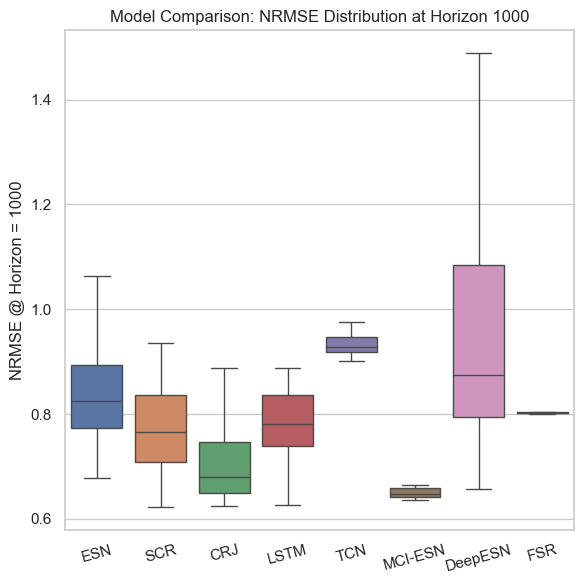

In [24]:
# import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Use integer key as your function returns {1000: value}
horizon = 1000
model_names = list(nrmse_dict.keys())

# Flatten NRMSEs for plotting
flattened_nrmse_data = {
    model: np.array([entry[horizon] for entry in nrmse_dict[model]])
    for model in model_names
}

# Create boxplot
plt.figure(figsize=(6, 6))
sns.boxplot(data=[flattened_nrmse_data[model] for model in model_names], orient="v", showfliers=False)

plt.xticks(ticks=range(len(model_names)), labels=model_names, rotation=15)
plt.ylabel("NRMSE @ Horizon = 1000")
plt.title("Model Comparison: NRMSE Distribution at Horizon 1000")

# Save high-resolution image
plt.tight_layout()
plt.savefig("nrmse_boxplot_h1000_mit.png", dpi=250)
plt.show()

In [25]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'LSTM':<17} {'TCN':<17} {'FSR':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    # sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    # hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]
    # hfr_vals = [np.mean(hfr_nrmse[horizon]) for hfr_nrmse in nrmse_dict['HFR']]
    fsr_vals = [np.mean(fsr_nrmse[horizon]) for fsr_nrmse in nrmse_dict['FSR']]
    tcn_vals = [np.mean(tcn_nrmse[horizon]) for tcn_nrmse in nrmse_dict['TCN']]
    lstm_vals = [np.mean(lstm_nrmse[horizon]) for lstm_nrmse in nrmse_dict['LSTM']]


    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, mci_vals, deep_vals, lstm_vals, tcn_vals, fsr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()



NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               MCI-ESN           DeepESN           LSTM              TCN               FSR              
--------------------------------------------------------------------------------------------------------------------------------------------
300        1.3575 ± 0.3162   1.1721 ± 0.3012   0.9054 ± 0.1944   0.6600 ± 0.0348   1.5803 ± 0.5559   0.8104 ± 0.0669   0.9357 ± 0.0250   0.7964 ± 0.0011   
600        1.0136 ± 0.2134   0.8906 ± 0.2000   0.7260 ± 0.1228   0.6089 ± 0.0189   1.1644 ± 0.3799   0.7836 ± 0.0692   0.9345 ± 0.0241   0.7981 ± 0.0008   
1000       0.8575 ± 0.1301   0.7918 ± 0.1155   0.6988 ± 0.0654   0.6502 ± 0.0090   0.9534 ± 0.2383   0.7844 ± 0.0639   0.9336 ± 0.0232   0.8025 ± 0.0007   


# Sunspot Dataset

In [26]:
import pandas as pd
file_path = '/kaggle/input/realworld-data/SN_m_tot_V2.0.csv'

df = pd.read_csv(file_path, sep=';', header = None)
df

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/realworld-data/SN_m_tot_V2.0.csv'

In [ ]:
data = df.iloc[:, 3].values
dt = 1
dataset_size = len(data)
data = create_delay_embedding(data, 3)
print(f"Dataset size: {dataset_size}")

# Train/Test Split
train_end = 2000
train_input  = data[:train_end]
train_target = data[1:train_end+1]
test_input   = data[train_end:-1]
test_target  = data[train_end+1:]
y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps) * dt

print(f"Train size: {len(train_input)}\nTest size: {len(test_input)}")

Dataset size: 3315
Train size: 2000
Test size: 1312


In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [300, 600, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1025)


for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.95,
        connectivity=0.05,
        input_scale=0.1,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight = 0.8,
        spectral_radius=0.95,
        input_scale=0.4,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=5,
        spectral_radius=0.95,
        input_scale=0.4,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)


for seed in seeds:  
    tcn = TCNBaseline3D(hidden_dim=32, epochs=40, lr=1e-3, device="cpu", seed=seed)
    tcn.fit(train_input, train_target)

    # initial window must be >4 samples:
    # init_win = test_input[:5].copy()    
    tcn_preds = tcn.predict_open_loop(test_input)
    nrmse = evaluate_nrmse(tcn_preds, test_target, horizons)
    nrmse_dict['TCN'].append(nrmse)

for seed in seeds:
    lstm_baseline = LSTMBaseline3D(
                        hidden_size=32,         # parameter budget ~ 4800
                        lr=1e-3,
                        epochs=400,
                        device='cuda' if torch.cuda.is_available() else 'cpu',
                        seed=seed)
    lstm_baseline.fit(train_input, train_target)

    # one-step roll-out to build an initial vector for auto-regressive mode
    init_vec = train_target[-1]                # last teacher-forced target
    lstm_preds = lstm_baseline.predict_open_loop(test_input)

    nrmse = evaluate_nrmse(lstm_preds, test_target, horizons)
    nrmse_dict['LSTM'].append(nrmse)


for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.01,
        connect_weight=0.1,
        combine_factor=0.1,
        v1=0.0003,
        v2=0.0003,
        spectral_radius=0.95,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.predict(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)


for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.95,
        input_scale=0.1,
        leaking_rate=0.6,
        ridge_alpha=1e-4,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)


for seed in seeds:
    fsr = FSR3D(
        reservoir_size=300,
        frequency_mode='gold',
        r_damp=0.01,
        eps_couple=0.1,
        input_scale=0.5,
        leak_rate=0.1,
        ridge_alpha=1e-08,
        use_gain=True,
        gain_beta=60,
        gain_sigmoid=True,
        use_quadratic_feat=True,
        seed=seed
    )
    fsr.fit_readout(train_input, train_target, discard=100)
    fsr_preds = fsr.predict_open_loop(test_input)
    fsr_nrmse = evaluate_nrmse(fsr_preds, test_target, horizons)
    nrmse_dict['FSR'].append(fsr_nrmse)

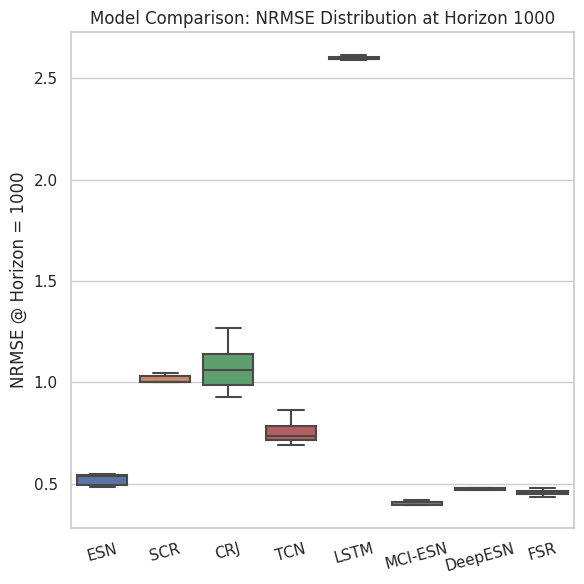

In [ ]:
# import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Use integer key as your function returns {1000: value}
horizon = 1000
model_names = list(nrmse_dict.keys())

# Flatten NRMSEs for plotting
flattened_nrmse_data = {
    model: np.array([entry[horizon] for entry in nrmse_dict[model]])
    for model in model_names
}

# Create boxplot
plt.figure(figsize=(6, 6))
sns.boxplot(data=[flattened_nrmse_data[model] for model in model_names], orient="v", showfliers=False)

plt.xticks(ticks=range(len(model_names)), labels=model_names, rotation=15)
plt.ylabel("NRMSE @ Horizon = 1000")
plt.title("Model Comparison: NRMSE Distribution at Horizon 1000")

# Save high-resolution image
plt.tight_layout()
plt.savefig("nrmse_boxplot_h1000_sun.png", dpi=250)
plt.show()


In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'LSTM':<17} {'TCN':<17} {'FSR':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    # sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    # hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]
    # hfr_vals = [np.mean(hfr_nrmse[horizon]) for hfr_nrmse in nrmse_dict['HFR']]
    fsr_vals = [np.mean(fsr_nrmse[horizon]) for fsr_nrmse in nrmse_dict['FSR']]
    tcn_vals = [np.mean(tcn_nrmse[horizon]) for tcn_nrmse in nrmse_dict['TCN']]
    lstm_vals = [np.mean(lstm_nrmse[horizon]) for lstm_nrmse in nrmse_dict['LSTM']]


    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, mci_vals, deep_vals, lstm_vals, tcn_vals, fsr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()



NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               MCI-ESN           DeepESN           LSTM              TCN               FSR              
--------------------------------------------------------------------------------------------------------------------------------------------
300        0.6001 ± 0.0214   1.1092 ± 0.1324   1.2168 ± 0.1859   0.4675 ± 0.0091   0.5850 ± 0.0247   2.6787 ± 0.0107   0.9325 ± 0.0666   0.5152 ± 0.0106   
600        0.5496 ± 0.0295   1.0116 ± 0.1304   1.1289 ± 0.1567   0.4234 ± 0.0140   0.5015 ± 0.0232   2.5410 ± 0.0082   0.7743 ± 0.0624   0.4730 ± 0.0274   
1000       0.5229 ± 0.0263   0.9605 ± 0.1217   1.0770 ± 0.1192   0.4060 ± 0.0100   0.4802 ± 0.0196   2.5997 ± 0.0086   0.7578 ± 0.0616   0.4565 ± 0.0150   


# Sante Fe Dataset

In [ ]:
import pandas as pd

file_path = '/kaggle/input/realworld-data/b1.txt'

df = pd.read_csv(file_path, header=None, sep=' ')
df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,0,1,2,3
0,76.53,8320,7771,NaN
1,76.53,8117,7774,NaN
2,76.15,7620,7788,NaN
3,75.39,6413,7787,NaN
4,75.51,7518,7767,NaN
...,...,...,...,...
16995,73.57,16021,6498,NaN
16996,73.79,-6957,6547,NaN
16997,74.54,11476,6576,NaN
16998,74.36,15058,6573,NaN


In [ ]:
# Normalize the first column (column 0) of the DataFrame
df[0] = (df[0] - df[0].min()) / (df[0].max() - df[0].min())

In [ ]:
data = df.iloc[:, 0].values
chosen_system = "SantaFe"
dt = 1
T_data = len(data)
data = create_delay_embedding(data, 3)
print(f"Data length: {T_data}.")

# Train/Test Split
train_end = 7000
train_input  = data[:train_end]
train_target = data[1:train_end+1]
test_input   = data[train_end:-1]
test_target  = data[train_end+1:]
y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps) * dt

print(f"Train size: {len(train_input)}  \nTest size: {len(test_input)}")


Data length: 17000.
Train size: 7000  
Test size: 9997


In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [300, 600, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1025)

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.95,
        connectivity=0.05,
        input_scale=0.1,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight = 0.8,
        spectral_radius=0.99,
        input_scale=0.4,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=500,
        edge_weight=0.8,
        jump=15,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

for seed in seeds:
    lstm_baseline = LSTMBaseline3D(
                        hidden_size=32,         # parameter budget ~ 4800
                        lr=1e-3,
                        epochs=400,
                        device='cuda' if torch.cuda.is_available() else 'cpu',
                        seed=seed)
    lstm_baseline.fit(train_input, train_target)

    # one-step roll-out to build an initial vector for auto-regressive mode
    init_vec = train_target[-1]                # last teacher-forced target
    lstm_preds = lstm_baseline.predict_open_loop(test_input)

    nrmse = evaluate_nrmse(lstm_preds, test_target, horizons)
    nrmse_dict['LSTM'].append(nrmse)

for seed in seeds:  
    tcn = TCNBaseline3D(hidden_dim=32, epochs=100, lr=1e-3, device="cpu", seed=seed)
    tcn.fit(train_input, train_target)

    # initial window must be >4 samples:
    # init_win = test_input[:5].copy()    
    tcn_preds = tcn.predict_open_loop(test_input)
    nrmse = evaluate_nrmse(tcn_preds, test_target, horizons)
    nrmse_dict['TCN'].append(nrmse)



for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=1,
        connect_weight=1,
        combine_factor=0.5,
        v1=0.8,
        v2=0.8,
        spectral_radius=0.95,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.predict(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)


for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.95,
        input_scale=0.2,
        leaking_rate=0.9,
        ridge_alpha=1e-4,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

for seed in seeds:
    fsr = FSR3D(
        reservoir_size=300,
        frequency_mode='gold',
        r_damp=0.01,
        eps_couple=0.1,
        input_scale=0.5,
        leak_rate=0.1,
        ridge_alpha=1e-08,
        use_gain=True,
        gain_beta=60,
        gain_sigmoid=True,
        use_quadratic_feat=True,
        seed=seed
    )
    fsr.fit_readout(train_input, train_target, discard=100)
    fsr_preds = fsr.predict_open_loop(test_input)
    fsr_nrmse = evaluate_nrmse(fsr_preds, test_target, horizons)
    nrmse_dict['FSR'].append(fsr_nrmse)

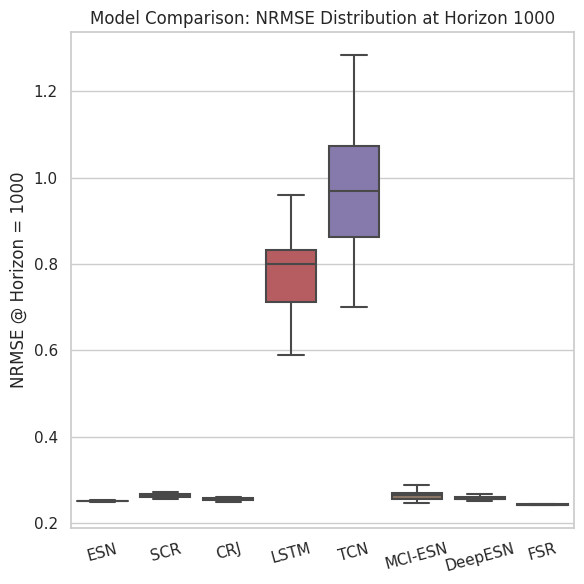

In [ ]:
# import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Use integer key as your function returns {1000: value}
horizon = 1000
model_names = list(nrmse_dict.keys())

# Flatten NRMSEs for plotting
flattened_nrmse_data = {
    model: np.array([entry[horizon] for entry in nrmse_dict[model]])
    for model in model_names
}

# Create boxplot
plt.figure(figsize=(6, 6))
sns.boxplot(data=[flattened_nrmse_data[model] for model in model_names], orient="v", showfliers=False)

plt.xticks(ticks=range(len(model_names)), labels=model_names, rotation=15)
plt.ylabel("NRMSE @ Horizon = 1000")
plt.title("Model Comparison: NRMSE Distribution at Horizon 1000")

# Save high-resolution image
plt.tight_layout()
plt.savefig("nrmse_boxplot_h1000_santa.png", dpi=250)
plt.show()


In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'LSTM':<17} {'TCN':<17} {'FSR':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    # sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    # hypER_vals = [np.mean(hypER_nrmse[horizon]) for hypER_nrmse in nrmse_dict['HypER']]
    # hfr_vals = [np.mean(hfr_nrmse[horizon]) for hfr_nrmse in nrmse_dict['HFR']]
    fsr_vals = [np.mean(fsr_nrmse[horizon]) for fsr_nrmse in nrmse_dict['FSR']]
    tcn_vals = [np.mean(tcn_nrmse[horizon]) for tcn_nrmse in nrmse_dict['TCN']]
    lstm_vals = [np.mean(lstm_nrmse[horizon]) for lstm_nrmse in nrmse_dict['LSTM']]


    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, mci_vals, deep_vals, lstm_vals, tcn_vals, fsr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()



NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               MCI-ESN           DeepESN           LSTM              TCN               FSR              
--------------------------------------------------------------------------------------------------------------------------------------------
300        0.2758 ± 0.0014   0.2924 ± 0.0032   0.2858 ± 0.0047   0.2694 ± 0.0031   0.2873 ± 0.0038   1.0226 ± 0.1413   1.2064 ± 0.1806   0.2671 ± 0.0019   
600        0.2364 ± 0.0014   0.2521 ± 0.0053   0.2413 ± 0.0037   0.2609 ± 0.0217   0.2435 ± 0.0049   0.7024 ± 0.0866   0.8929 ± 0.1252   0.2249 ± 0.0010   
1000       0.2509 ± 0.0010   0.2639 ± 0.0043   0.2562 ± 0.0031   0.2677 ± 0.0175   0.2576 ± 0.0039   0.7801 ± 0.0944   0.9639 ± 0.1338   0.2428 ± 0.0009   
